In [4]:
import pandas as pd
import datetime as dt
import pandas_datareader as pdr
import numpy as np
import praw
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from praw.models import MoreComments
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error



In [5]:
import yfinance as yf

data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "TSLA",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "2y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1h",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = False
    )
data.to_csv("TSLA2.csv")

[*********************100%***********************]  1 of 1 completed


In [34]:

pd.set_option('display.max_columns', 20)

stock_symbol = 'MSFT'
stock_search = 'MSFT'
stock_date = '2020-01-01'

df = pd.read_csv('msft_with_sentiment.csv', date_parser = True)
df = df.set_index('Date', drop = True)

# Create short simple moving average over the short window
df['short_mavg'] = df['Close'].rolling(window=5, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
df['long_mavg'] = df['Close'].rolling(window=30, min_periods=1, center=False).mean()

# Create signals
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

df.index = pd.to_datetime(df.index)

data_training = df.loc[(df.index <= stock_date)]
data_test = df.loc[(df.index >= stock_date)]

data_test = data_test.reset_index()
data_training = data_training.reset_index()


print(data_training.shape)
print(data_training[(data_training.signal > 0) & (data_training.Polarity != 0)].head())


data_training = data_training.drop(['Date', 'Polarity'], axis = 1)
data_training_test = data_training
data_test = data_test.drop(['Date', 'Polarity'], axis = 1)



(695, 11)
         Date       Open       High        Low      Close  Adj Close  \
6  2017-01-11  62.610001  63.230000  62.430000  63.189999  59.109024   
7  2017-01-12  63.060001  63.400002  61.950001  62.610001  58.566483   
8  2017-01-13  62.619999  62.869999  62.349998  62.700001  58.650673   
9  2017-01-17  62.680000  62.700001  62.029999  62.529999  58.491653   
10 2017-01-18  62.669998  62.700001  62.119999  62.500000  58.463589   

      Volume  Polarity  short_mavg  long_mavg  signal  
6   21517300 -0.981695   62.717999  62.638571     1.0  
7   20968200 -0.977989   62.780000  62.635000     1.0  
8   19422300 -0.479741   62.752000  62.642222     1.0  
9   20664000 -0.996626   62.730000  62.631000     1.0  
10  19670100 -0.999345   62.706000  62.619091     1.0  


In [81]:
# The values in the training data are not in the same range
# For getting all the values in between the range 0 to 1 use MinMaxScalar() 
# to improves the accuracy of prediction
scaler = MinMaxScaler()
data_training_normalized = scaler.fit_transform(data_training)
print(data_training)

# This sections of the code divides the data into chunks of 10 rows corresponds to 
# the length of data_traning. After dividing we are converting X_train and y_train
# into numpy arrays
X_train = []
y_train = []

for i in range(10, data_training_normalized.shape[0]):
    X_train.append(data_training_normalized[i-10:i])
    y_train.append(data_training_normalized[i, 8])
    
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)


           Open        High         Low       Close   Adj Close    Volume  \
0     62.790001   62.840000   62.130001   62.580002   58.538418  20694100   
1     62.480000   62.750000   62.119999   62.299999   58.276497  21340000   
2     62.189999   62.660000   62.029999   62.299999   58.276497  24876000   
3     62.299999   63.150002   62.040001   62.840000   58.781628  19922900   
4     62.759998   63.080002   62.540001   62.639999   58.594547  20382700   
..          ...         ...         ...         ...         ...       ...   
690  158.119995  158.119995  157.270004  157.410004  155.402023  17718200   
691  157.479996  157.710007  157.119995  157.380005  155.372406   8989200   
692  157.559998  158.729996  157.399994  158.669998  156.645950  14520600   
693  159.449997  159.550003  158.220001  158.960007  156.932251  18412800   
694  158.990005  159.020004  156.729996  157.589996  155.579727  16348400   

     short_mavg   long_mavg  signal  
0     62.580002   62.580002     0.0  

In [35]:
# Build model
model = Sequential()

X_train.shape[1]

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 60)            16800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 60)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 60)            29040     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 60)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 80)            45120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 120)               96480     
__________

In [55]:
# past_10_days contains the data of the past 10 days required to predict the opening of the 1st day in the test data set.
past_10_days = data_training_test.tail(10)
print(past_10_days)

# We are going to append data_test to past_10_days and ignore the index of data_test
df = past_10_days.append(data_test, ignore_index = True)
print(df.head())

# Similar to the training data set we have to scale the test data so that all the values are in the range 0 to 1.
inputs = scaler.fit_transform(df)
print(inputs)

# Prepare the test data like the training data.
X_test = []
y_test = []

for i in range(10, inputs.shape[0]):
    X_test.append(inputs[i-10:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

y_pred = model.predict(X_test)

print(y_test)

# Calcualte the original price back again
scale = 1/scaler.scale_[0]
print(scale)

# Prediction on the normal price scale
y_pred = y_pred*scale
y_test = y_test*scale

           Open        High         Low       Close   Adj Close    Volume  \
685  155.110001  155.899994  154.820007  155.529999  153.546005  24144200   
686  155.449997  155.710007  154.449997  154.690002  152.716705  25425600   
687  154.300003  155.479996  154.179993  154.369995  152.400803  24129200   
688  154.000000  155.770004  153.750000  155.710007  153.723709  24958900   
689  157.350006  158.490005  156.289993  157.410004  155.402023  53477500   
690  158.119995  158.119995  157.270004  157.410004  155.402023  17718200   
691  157.479996  157.710007  157.119995  157.380005  155.372406   8989200   
692  157.559998  158.729996  157.399994  158.669998  156.645950  14520600   
693  159.449997  159.550003  158.220001  158.960007  156.932251  18412800   
694  158.990005  159.020004  156.729996  157.589996  155.579727  16348400   

     short_mavg   long_mavg  signal  
685  153.226001  149.535667     1.0  
686  153.938000  149.873667     1.0  
687  154.472000  150.204000     1.0  


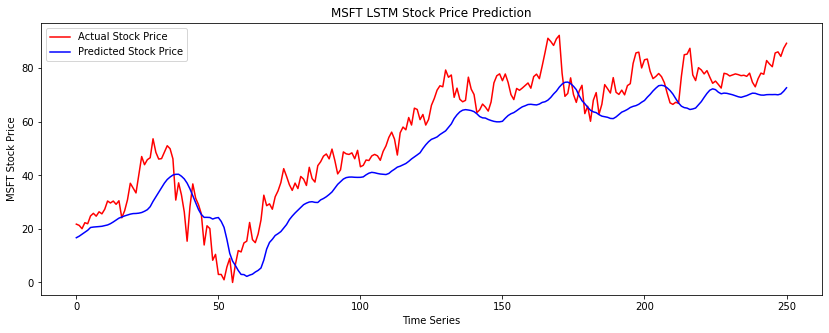

In [56]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title(stock_symbol + ' LSTM Stock Price Prediction')
plt.xlabel('Time Series')
plt.ylabel(stock_symbol + ' Stock Price')
plt.legend()
plt.show()


In [83]:
# Prediction on Signals
# 
#  past_10_days contains the data of the past 10 days required to predict the opening of the 1st day in the test data set.
past_10_days = data_training_test.tail(10)
print(past_10_days)

# We are going to append data_test to past_10_days and ignore the index of data_test
df = past_10_days.append(data_test, ignore_index = True)
print(df.head())

# Similar to the training data set we have to scale the test data so that all the values are in the range 0 to 1.
inputs = scaler.fit_transform(df)
#inputs = np.delete(inputs, [1,2,3,4,5,6,7], axis=1)
print(inputs.shape)


# Prepare the test data like the training data.
X_test = []
y_test = []

for i in range(10, inputs.shape[0]):
    X_test.append(inputs[i-10:i])
    y_test.append(inputs[i, 8])

X_test, y_test = np.array(X_test), np.array(y_test)

print("--------")
print(X_test.shape)

y_pred = model.predict(X_test)

print(y_pred.shape)

# Calcualte the original price back again
scale = 1/scaler.scale_[8]
print(scale)

# Prediction on the normal price scale
y_pred = y_pred*scale
y_test = y_test*scale

           Open        High         Low       Close   Adj Close    Volume  \
685  155.110001  155.899994  154.820007  155.529999  153.546005  24144200   
686  155.449997  155.710007  154.449997  154.690002  152.716705  25425600   
687  154.300003  155.479996  154.179993  154.369995  152.400803  24129200   
688  154.000000  155.770004  153.750000  155.710007  153.723709  24958900   
689  157.350006  158.490005  156.289993  157.410004  155.402023  53477500   
690  158.119995  158.119995  157.270004  157.410004  155.402023  17718200   
691  157.479996  157.710007  157.119995  157.380005  155.372406   8989200   
692  157.559998  158.729996  157.399994  158.669998  156.645950  14520600   
693  159.449997  159.550003  158.220001  158.960007  156.932251  18412800   
694  158.990005  159.020004  156.729996  157.589996  155.579727  16348400   

     short_mavg   long_mavg  signal  
685  153.226001  149.535667     1.0  
686  153.938000  149.873667     1.0  
687  154.472000  150.204000     1.0  


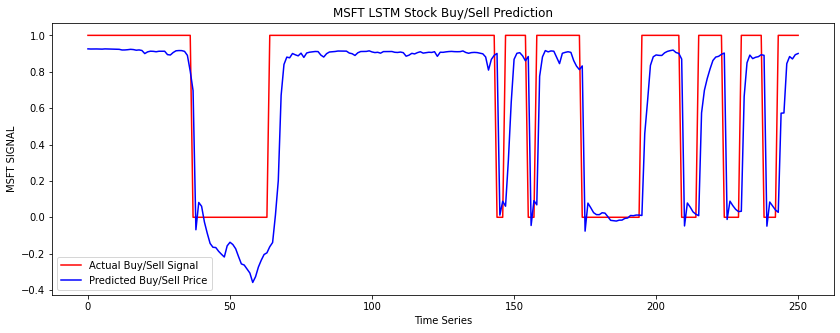

In [86]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Actual Buy/Sell Signal ')
plt.plot(y_pred, color = 'blue', label = 'Predicted Buy/Sell Price')
plt.title(stock_symbol + ' LSTM Stock Buy/Sell Prediction')
plt.xlabel('Time Series')
plt.ylabel(stock_symbol + ' SIGNAL')
plt.legend()
plt.show()

In [46]:
print("---- LSTM SCORE ------")
#test_loss, test_accuracy = model.evaluate(X_test, y_test)

from sklearn.metrics import average_precision_score, confusion_matrix, classification_report
print(average_precision_score(y_test, y_pred))

for x in range(y_pred.size):
    if (y_pred[x] < 0.8):
        y_pred[x] = 0
    else:
        y_pred[x] = 1

cm = confusion_matrix(y_test, y_pred)
print(cm)

class_names = ['Sell', 'Buy']
print(classification_report(y_test, y_pred, target_names=class_names,digits=3))


---- LSTM SCORE ------
0.937559184962554
[[ 64   7]
 [ 16 164]]
              precision    recall  f1-score   support

        Sell      0.800     0.901     0.848        71
         Buy      0.959     0.911     0.934       180

    accuracy                          0.908       251
   macro avg      0.880     0.906     0.891       251
weighted avg      0.914     0.908     0.910       251



In [39]:
MSE_error = mean_squared_error(y_test, y_pred)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 0.29570966168125046


In [37]:
# Create short simple moving average over the short window
df['short_mavg'] = df['Close'].rolling(window=5, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
df['long_mavg'] = df['Close'].rolling(window=30, min_periods=1, center=False).mean()

# Create signals
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]

training_data = train_data['signal'].values
test_data = test_data['signal'].values

history = [x for x in training_data]

model_predictions = []
N_test_observations = len(test_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
Testing Mean Squared Error is 0.04927174637602427


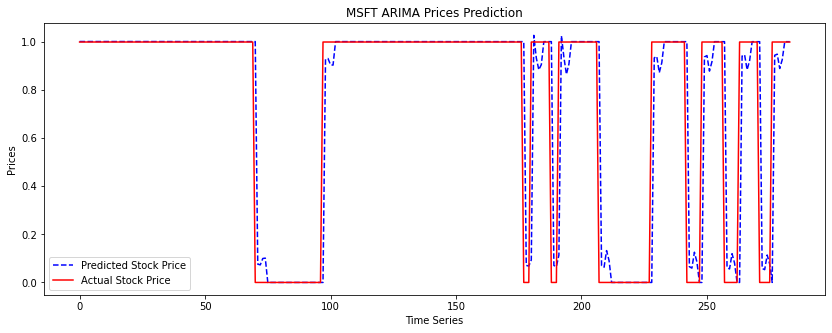

In [38]:
# Visualising the results
test_set_range = df[int(len(df)*0.7):].index

plt.figure(figsize=(14,5))
plt.plot(model_predictions, color='blue', linestyle='dashed',label='Predicted Stock Price')
plt.plot(test_data, color='red', label='Actual Stock Price')
plt.title('MSFT ARIMA Prices Prediction')
plt.xlabel('Time Series')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [47]:
print("---- ARIMA SCORE ------")

from sklearn.metrics import average_precision_score, confusion_matrix, classification_report
print(average_precision_score(test_data, model_predictions))

for x in range(0, len(model_predictions)):
    if (model_predictions[x] < 0.8):
        model_predictions[x] = 0
    else:
        model_predictions[x] = 1

cm = confusion_matrix(y_test, y_pred)
print(cm)

class_names = ['Sell', 'Buy']
print(classification_report(test_data, model_predictions, target_names=class_names,digits=3))


---- ARIMA SCORE ------
0.9600002204148206
[[ 64   7]
 [ 16 164]]
              precision    recall  f1-score   support

        Sell      0.901     0.901     0.901        71
         Buy      0.967     0.967     0.967       213

    accuracy                          0.951       284
   macro avg      0.934     0.934     0.934       284
weighted avg      0.951     0.951     0.951       284



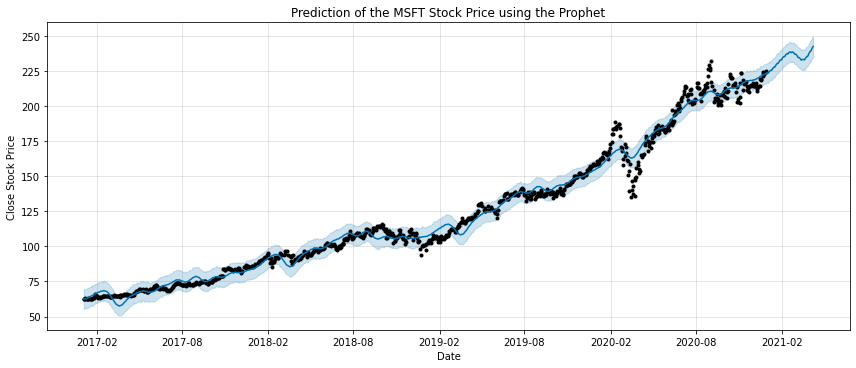

             ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2017-01-03   63.214337   55.182402   69.214282    63.214337    63.214337   
1    2017-01-04   63.222859   55.674627   69.702471    63.222859    63.222859   
2    2017-01-05   63.231380   56.034519   69.546639    63.231380    63.231380   
3    2017-01-06   63.239901   55.699005   69.553358    63.239901    63.239901   
4    2017-01-09   63.265466   55.963471   69.636104    63.265466    63.265466   
...         ...         ...         ...         ...          ...          ...   
1041 2021-04-04  242.449030  232.653438  247.191345   240.693820   244.292488   
1042 2021-04-05  242.641726  233.159744  247.885014   240.852125   244.528762   
1043 2021-04-06  242.834422  233.922262  248.739014   241.022667   244.747748   
1044 2021-04-07  243.027117  234.359898  249.142254   241.182393   244.997441   
1045 2021-04-08  243.219813  235.230944  249.530042   241.337737   245.240275   

      additive_terms  addit

In [42]:
from fbprophet import Prophet

df = pd.read_csv('msft_with_sentiment.csv', date_parser = True)
df = df.set_index('Date', drop = True)
df.index = pd.to_datetime(df.index)
training_data = df.loc[(df.index) >= '2017-01-03']
training_data.rename(columns={'Close': 'y'},inplace=True)
training_data['ds'] = pd.to_datetime(training_data.index)
training_data['y'] = training_data['y'].astype(float)

m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(training_data) # fit the model using training data

future = m.make_future_dataframe(periods=100) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction, figsize=(12, 5))
plt.title("Prediction of the MSFT Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

print(prediction)

print(prediction[['ds', 'trend']])


In [43]:
for i in range(len(X_test)):
    if (y_pred[i] - y_pred[i-1] > 0):
        print("{0} Buy".format(y_pred[i]))
    else:
        print("{0} Sell".format(y_pred[i]))


[0.21408099] Sell
[0.21689378] Buy
[0.22138171] Buy
[0.22691597] Buy
[0.23093726] Buy
[0.23566927] Buy
[0.23691536] Buy
[0.2372471] Buy
[0.2384988] Buy
[0.2405671] Buy
[0.24412932] Buy
[0.24684285] Buy
[0.25062758] Buy
[0.25617972] Buy
[0.26293978] Buy
[0.26977888] Buy
[0.27444032] Buy
[0.27870965] Buy
[0.2812309] Buy
[0.28385314] Buy
[0.28567123] Buy
[0.28575015] Buy
[0.28835872] Buy
[0.29355896] Buy
[0.2991147] Buy
[0.30475017] Buy
[0.31551695] Buy
[0.3355215] Buy
[0.35450858] Buy
[0.37397254] Buy
[0.39220765] Buy
[0.41124928] Buy
[0.4270019] Buy
[0.4372936] Buy
[0.44555604] Buy
[0.447232] Buy
[0.44678587] Sell
[0.43835446] Sell
[0.42908594] Sell
[0.41489014] Sell
[0.3898538] Sell
[0.35772318] Sell
[0.32697457] Sell
[0.30429953] Sell
[0.28976583] Sell
[0.287243] Sell
[0.29450226] Buy
[0.3021751] Buy
[0.29915464] Sell
[0.2986307] Sell
[0.2977315] Sell
[0.28295296] Sell
[0.26416212] Sell
[0.24087062] Sell
[0.21134777] Sell
[0.17495683] Sell
[0.14208767] Sell
[0.1048371] Sell
[0.0754981